In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!unzip -q "/content/gdrive/My Drive/Data_science/EIP/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

gdrive/  hvc_annotations.csv  resized/  sample_data/


In [3]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import os


Using TensorFlow backend.


In [4]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [5]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True, augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        image = image.astype('float32') / 255
        image_mean = np.mean(image, axis=0)
        image -= image_mean

        if self.augmentation is not None:
          image = self.augmentation.flow(image, shuffle=False).next()
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [7]:
_gender_cols_

['gender_female', 'gender_male']

In [8]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [9]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
1825,resized/1826.jpg,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0
6827,resized/6828.jpg,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0
626,resized/627.jpg,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0
8852,resized/8853.jpg,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0
11690,resized/11692.jpg,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1


In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32,augmentation=ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=False,
        shear_range=0.2,
        zoom_range=0.2

    ))
valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False)

In [11]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [0]:
backbone = VGG16(
    weights="imagenet", 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)

neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.3)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

In [0]:
# freeze backbone
for layer in backbone.layers:
	layer.trainable = False

In [0]:
# losses = {
# 	"gender_output": "binary_crossentropy",
# 	"image_quality_output": "categorical_crossentropy",
# 	"age_output": "categorical_crossentropy",
# 	"weight_output": "categorical_crossentropy",

# }
# loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}
opt = SGD(lr=0.001, momentum=0.9)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [0]:
# model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=10)

In [0]:
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=10,
    verbose=1
)

In [0]:
from keras.models import Model
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.layers import AveragePooling2D, Input, Flatten
from keras.callbacks import LearningRateScheduler,ModelCheckpoint

In [0]:
def conv_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 dropout=True):
  conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  activation='relu' )
  x= inputs
  x=conv(x)
  x=BatchNormalization()(x)
  if dropout :
    x= Dropout(0.1)(x)

  return x

def max_pol(inputs,
            pol_size=2,
            z_dim=20):
  pol= MaxPooling2D(pol_size)
  conv1= Conv2D(z_dim, (1,1), activation='relu')
  
  x= inputs
  x=pol(x)
  x= conv1(x)
  return x

def conv_block(inputs, n,z=8):
  
  x=inputs
  for i in range(n):
    x= conv_layer(x, num_filters=z)
    z=z*2
  return x


In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 0.1
    if epoch > 55:
        lr *= 0.5e-3
    elif epoch > 45:
        lr *= 1e-3
    elif epoch > 40:
        lr *= 1e-2
    elif epoch > 35:
        lr *= 1e-1
    elif epoch > 30:
        lr = 0.01  
    elif epoch > 25:
        lr = 0.3
    elif epoch > 20:
        lr = 0.5
    elif epoch > 10:
        lr = 0.3
    print('Learning rate: ', lr)
    return lr

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'OPD_Res_model.{epoch:03d}.h5' 
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_gender_output_acc',
                             verbose=1,
                             save_best_only=True)

In [15]:
inputs=Input(shape=(224, 224, 3))
x = conv_layer(inputs , num_filters=16 )
x=conv_block(x, n=4,z=8)
x=max_pol(x)

y=conv_block(x,4,z=32)
y=max_pol(y)
x=conv_layer(x,num_filters=20, strides=2)
x = keras.layers.add([x, y])

y=conv_block(x,4,z=32)
y=max_pol(y)
x=conv_layer(x,num_filters=20, strides=2)
x = keras.layers.add([x, y])

y=conv_block(x,4,z=32)
y=max_pol(y)
x=conv_layer(x,num_filters=20, strides=2)
x = keras.layers.add([x, y])

y=conv_block(x,2,z=32)
y=Conv2D(20, (1,1), activation='relu')(y)
x=keras.layers.add([x, y])
print(x.shape)
x=AveragePooling2D(pool_size=6)(x)
print(x.shape)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


(?, 14, 14, 20)

(?, 2, 2, 20)


In [0]:
neck = x
neck = Flatten(name="flatten")(neck)
neck = Dense(80, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.3)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))

In [0]:
Model_2=None

In [0]:
Model_2= Model(
    inputs=inputs, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

In [0]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [19]:
opt = SGD(lr=lr_schedule(0))
Model_2.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    #loss_weights=loss_weights, 
    metrics=["accuracy"]
)

Learning rate:  0.1




In [20]:
Model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 224, 224, 16) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

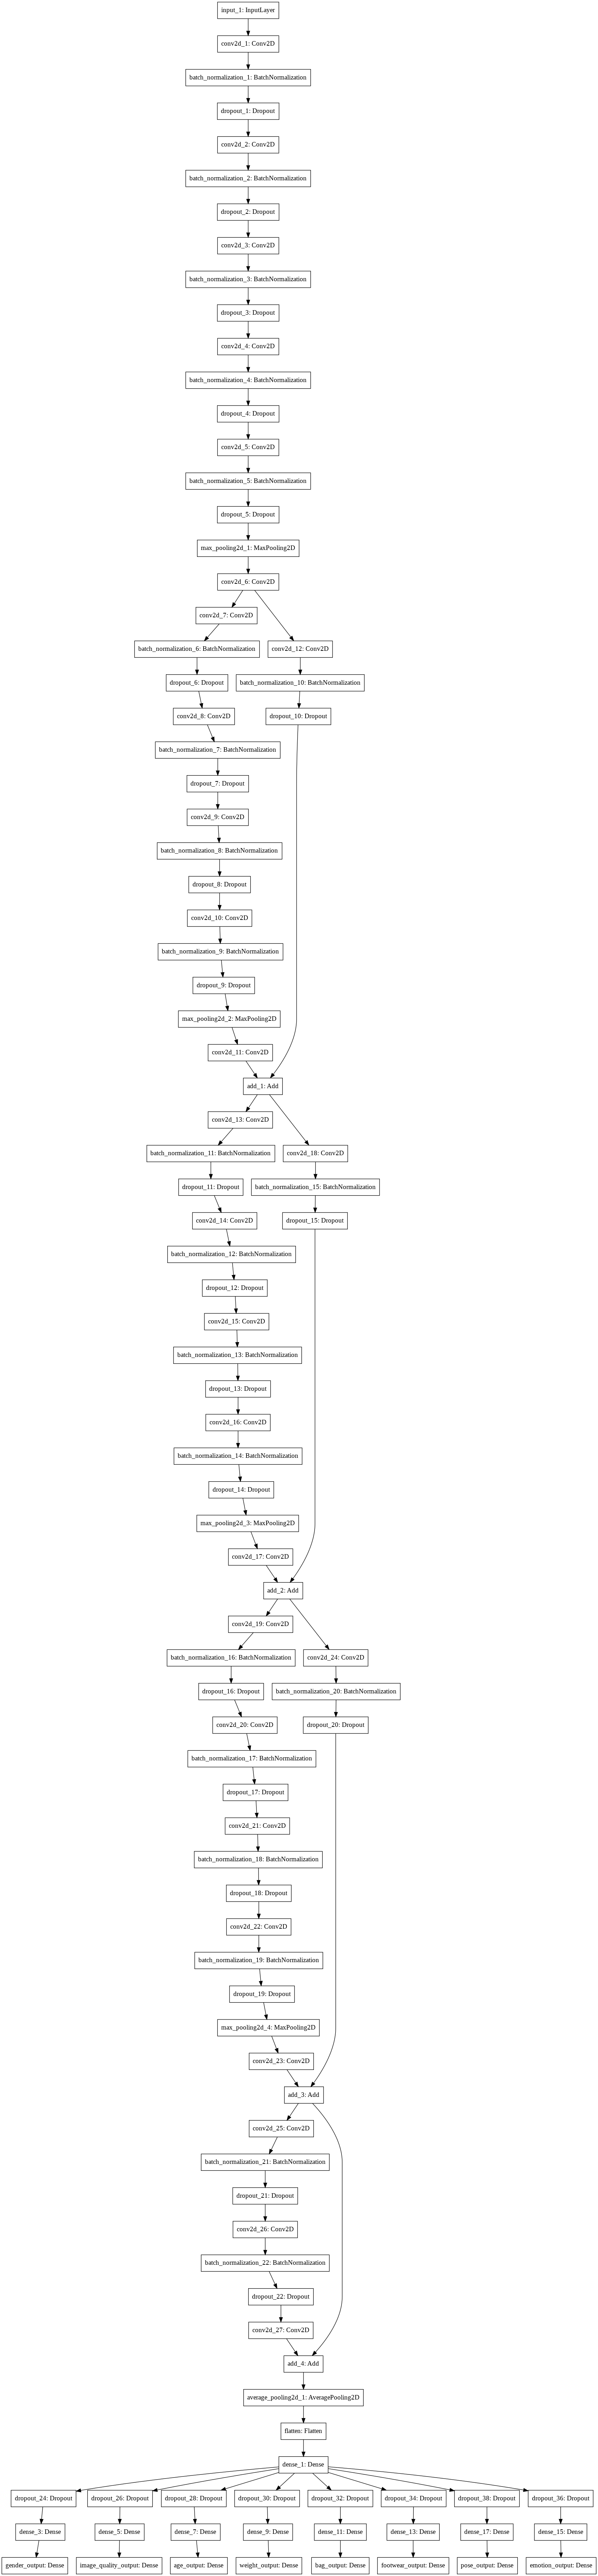

In [0]:
from keras.utils import plot_model
plot_model(Model_2, to_file='model__2.png')

In [0]:
t=Model_2.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=-1, 
    epochs=60,
    verbose=1,
    callbacks=[lr_scheduler,checkpoint]
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/60
Learning rate:  0.1
360/360 [==============================] - 281s 781ms/step - loss: 6.6960 - gender_output_loss: 0.4066 - image_quality_output_loss: 0.9423 - age_output_loss: 1.3672 - weight_output_loss: 0.9428 - bag_output_loss: 0.8353 - footwear_output_loss: 0.8063 - pose_output_loss: 0.5337 - emotion_output_loss: 0.8618 - gender_output_acc: 0.8087 - image_quality_output_acc: 0.5582 - age_output_acc: 0.4023 - weight_output_acc: 0.6386 - bag_output_acc: 0.6234 - footwear_output_acc: 0.6378 - pose_output_acc: 0.7852 - emotion_output_acc: 0.7146 - val_loss: 6.6565 - val_gender_output_loss: 0.3688 - val_image_quality_output_loss: 0.9478 - val_age_output_loss: 1.3880 - val_weight_output_loss: 0.9753 - val_bag_output_loss: 0.8238 - val_footwear_output_loss: 0.7827 - val_pose_output_loss: 0.4971 - val_emotion_output_loss: 0.8730 - val_gender_output_acc: 0.8402 - val_image_quality_ou

In [0]:
!zip -r /content/file.zip /content/saved_models/

  adding: content/saved_models/ (stored 0%)
  adding: content/saved_models/OPD_Res_model.029.h5 (deflated 11%)
  adding: content/saved_models/OPD_Res_model.043.h5 (deflated 11%)
  adding: content/saved_models/OPD_Res_model.001.h5 (deflated 12%)
  adding: content/saved_models/OPD_Res_model.016.h5 (deflated 11%)
  adding: content/saved_models/OPD_Res_model.009.h5 (deflated 11%)
  adding: content/saved_models/OPD_Res_model.020.h5 (deflated 11%)
  adding: content/saved_models/OPD_Res_model.003.h5 (deflated 11%)
  adding: content/saved_models/OPD_Res_model.027.h5 (deflated 11%)
  adding: content/saved_models/OPD_Res_model.006.h5 (deflated 11%)
  adding: content/saved_models/OPD_Res_model.021.h5 (deflated 11%)
  adding: content/saved_models/OPD_Res_model.031.h5 (deflated 11%)
  adding: content/saved_models/OPD_Res_model.004.h5 (deflated 11%)
  adding: content/saved_models/OPD_Res_model.049.h5 (deflated 11%)
  adding: content/saved_models/OPD_Res_model.011.h5 (deflated 11%)
  adding: content/

In [0]:
Model_2.load_weights('/content/OPD_Res_model.040.h5')

In [23]:
t=Model_2.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=-1, 
    epochs=60,
    verbose=1,
    callbacks=[lr_scheduler,checkpoint]
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/60
Learning rate:  0.1
360/360 [==============================] - 298s 827ms/step - loss: 6.3899 - gender_output_loss: 0.3213 - image_quality_output_loss: 0.9021 - age_output_loss: 1.3552 - weight_output_loss: 0.9292 - bag_output_loss: 0.8061 - footwear_output_loss: 0.7784 - pose_output_loss: 0.4384 - emotion_output_loss: 0.8591 - gender_output_acc: 0.8673 - image_quality_output_acc: 0.5700 - age_output_acc: 0.4107 - weight_output_acc: 0.6398 - bag_output_acc: 0.6470 - footwear_output_acc: 0.6571 - pose_output_acc: 0.8306 - emotion_output_acc: 0.7101 - val_loss: 6.2604 - val_gender_output_loss: 0.3030 - val_image_quality_output_loss: 0.9068 - val_age_output_loss: 1.3561 - val_weight_output_loss: 0.9133 - val_bag_output_loss: 0.8030 - val_footwear_output_loss: 0.7607 - val_pose_output_loss: 0.3980 - val_emotion_output_loss: 0.8194 - val_gender_output_acc: 0.8715 - val_image_quality_ou

In [24]:
Model_2.evaluate(valid_gen)

31/31 [==============================] - 7s 224ms/step


[6.149284885775659,
 0.25533257232558343,
 0.8882236807577072,
 1.3293709024306266,
 0.915084558148538,
 0.785568764132838,
 0.7614701082629542,
 0.3962345305950411,
 0.8179997109597729,
 0.8951612903225806,
 0.5730846774193549,
 0.4223790322580645,
 0.6507056451612904,
 0.6628024193548387,
 0.6799395161290323,
 0.858366935483871,
 0.7232862903225806]